In [1]:
import random
import numpy as np
import pandas as pd
import altair as alt

# Epsilon Greedy

In [2]:
class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts # Count represent counts of pulls for each arm. For multiple arms, this will be a list of counts.
        self.values = values # Value represent average reward for specific arm. For multiple arms, this will be a list of values.
        return 
    
    # Initialise k number of arms
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    # Epsilon greedy arm selection
    def select_arm(self):
        # If prob is not in epsilon, do exploitation of best arm so far
        if random.random() > self.epsilon:
            return np.argmax(self.values)
        # If prob falls in epsilon range, do exploration
        else:
            return random.randrange(len(self.values))
    
    # Choose to update chosen arm and reward
    def update(self, chosen_arm, reward):
        # update counts pulled for chosen arm
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        # Update average/mean value/reward for chosen arm
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [3]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    
    # Reward system based on Bernoulli
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0
        

In [4]:
def test_algorithm(algo, arms, num_sims, horizon):
    
    # Initialise variables for duration of accumulated simulation (num_sims * horizon_per_simulation)
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims *horizon)]
    times = [0.0 for i in range (num_sims*horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim -1) * horizon + t -1
            sim_nums[index] = sim
            times[index] = t
            
            # Selection of best arm and engaging it
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            # Engage chosen Bernoulli Arm and obtain reward info
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t ==1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward
                
            algo.update(chosen_arm, reward)
    
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [53]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_epsg_results.tsv", "w+")

# Create simulations for each exploration epsilon value
for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 5000, 250)
    
    # Store data
    for i in range(len(results[0])):
        f.write(str(epsilon) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [54]:
df = pd.read_csv("standard_epsg_results.tsv", sep = "\t", header = None, names = ["epsilon", "simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,epsilon,simulation_num,step,chosen_arm,reward,cum_reward
0,0.1,1,1,0,0.0,0.0
1,0.1,1,2,0,0.0,0.0
2,0.1,1,3,0,0.0,0.0
3,0.1,1,4,0,0.0,0.0
4,0.1,1,5,0,0.0,0.0


In [55]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [56]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["epsilon","step", "chose_correct"]].groupby(["epsilon","step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

In [57]:
df_chose_correctly.head()

,epsilon,step,chose_correct
0,0.1,1,0.0184
1,0.1,2,0.0372
2,0.1,3,0.0514
3,0.1,4,0.0696
4,0.1,5,0.0822


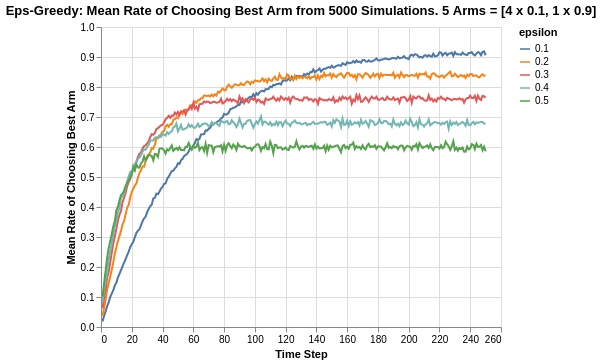

In [58]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm"),
    color = alt.Color("epsilon:N")
).properties(
    title = "Eps-Greedy: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [59]:
df_cumreward = df.loc[:,["epsilon","step", "cum_reward"]].groupby(["epsilon","step"]).agg("mean").reset_index()

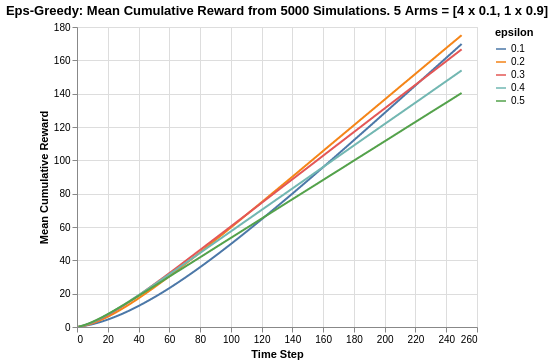

In [60]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward"),
    color = alt.Color("epsilon:N")
).properties(
    title = "Eps-Greedy: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [13]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.8, 0.8, 0.8, 0.8, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_epsg_results1.tsv", "w+")

# Create simulations for each exploration epsilon value
for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 5000, 250)
    
    # Store data
    for i in range(len(results[0])):
        f.write(str(epsilon) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [14]:
df = pd.read_csv("standard_epsg_results1.tsv", sep = "\t", header = None, names = ["epsilon", "simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,epsilon,simulation_num,step,chosen_arm,reward,cum_reward
0,0.1,1,1,0,1.0,1.0
1,0.1,1,2,0,1.0,2.0
2,0.1,1,3,0,0.0,2.0
3,0.1,1,4,0,1.0,3.0
4,0.1,1,5,0,1.0,4.0


In [15]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [16]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["epsilon","step", "chose_correct"]].groupby(["epsilon","step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

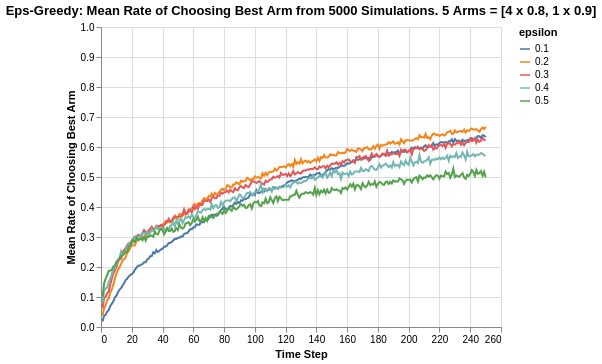

In [17]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
    color = alt.Color("epsilon:N")
).properties(
    title = "Eps-Greedy: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

In [18]:
df_cumreward = df.loc[:,["epsilon","step", "cum_reward"]].groupby(["epsilon","step"]).agg("mean").reset_index()

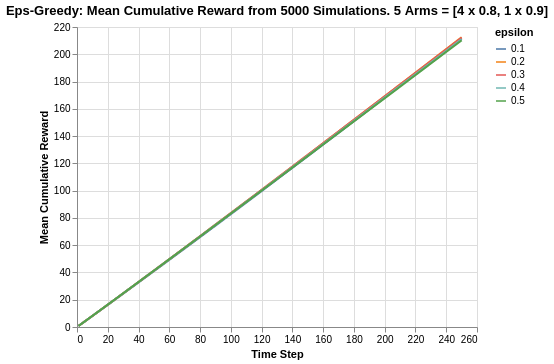

In [19]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward"),
    color = alt.Color("epsilon:N")
).properties(
    title = "Eps-Greedy: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

# Softmax Algorithm

In [20]:
import math
import random
def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        
        if cum_prob > z:
            return i
    return len(probs) - 1


In [21]:
class Softmax:
    def __init__(self, temperature, counts, values):
        self.temperature = temperature
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    def select_arm(self):
        z = sum([math.exp(v / self.temperature) for v in self.values])
        probs = [math.exp(v / self.temperature) / z for v in self.values]
        return categorical_draw(probs)
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [22]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_softmax_results.tsv", "w+")

# Create simulations for each temperature value
for temperature in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = Softmax(temperature, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 5000, 250)
    
    # Store data
    for i in range(len(results[0])):
        f.write(str(temperature) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [23]:
df = pd.read_csv("standard_softmax_results.tsv", sep = "\t", header = None, names = ["temperature", "simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,temperature,simulation_num,step,chosen_arm,reward,cum_reward
0,0.1,1,1,2,1.0,1.0
1,0.1,1,2,2,1.0,2.0
2,0.1,1,3,2,1.0,3.0
3,0.1,1,4,2,1.0,4.0
4,0.1,1,5,2,1.0,5.0


In [24]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [25]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["temperature","step", "chose_correct"]].groupby(["temperature","step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

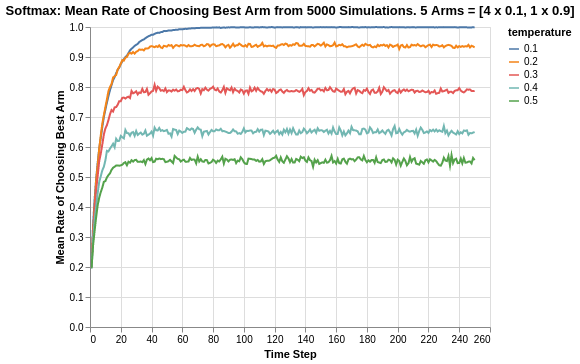

In [26]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
    color = alt.Color("temperature:N")
).properties(
    title = "Softmax: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [27]:
df_cumreward = df.loc[:,["temperature","step", "cum_reward"]].groupby(["temperature","step"]).agg("mean").reset_index()

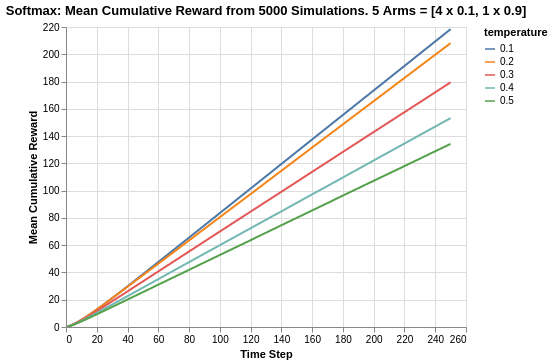

In [28]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward"),
    color = alt.Color("temperature:N")
).properties(
    title = "Softmax: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [29]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.8, 0.8, 0.8, 0.8, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_softmax_results1.tsv", "w+")

# Create simulations for each temperature value
for temperature in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = Softmax(temperature, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 5000, 250)
    
    # Store data
    for i in range(len(results[0])):
        f.write(str(temperature) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [30]:
df = pd.read_csv("standard_softmax_results1.tsv", sep = "\t", header = None, names = ["temperature", "simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,temperature,simulation_num,step,chosen_arm,reward,cum_reward
0,0.1,1,1,2,1.0,1.0
1,0.1,1,2,2,1.0,2.0
2,0.1,1,3,2,1.0,3.0
3,0.1,1,4,2,1.0,4.0
4,0.1,1,5,2,1.0,5.0


In [31]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [32]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["temperature","step", "chose_correct"]].groupby(["temperature","step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

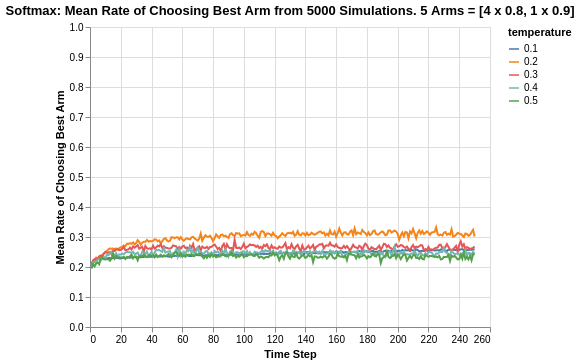

In [33]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
    color = alt.Color("temperature:N")
).properties(
    title = "Softmax: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

In [34]:
df_cumreward = df.loc[:,["temperature","step", "cum_reward"]].groupby(["temperature","step"]).agg("mean").reset_index()

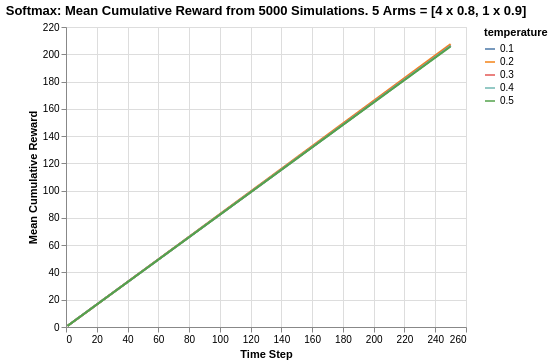

In [35]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward"),
    color = alt.Color("temperature:N")
).properties(
    title = "Softmax: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

# UCB 

In [36]:
class UCB1():
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    def select_arm(self):
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm
    
        ucb_values = [0.0 for arm in range(n_arms)]
        total_counts = sum(self.counts)
        
        for arm in range(n_arms):
            bonus = math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))
            ucb_values[arm] = self.values[arm] + bonus
        return ucb_values.index(max(ucb_values))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [37]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_ucb_results.tsv", "w+")

# Create simulations for each exploration epsilon value
algo = UCB1([], [])
algo.initialize(n_arms)
results = test_algorithm(algo, arms, 5000, 250)
    
# Store data
for i in range(len(results[0])):
    f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [38]:
df = pd.DataFrame(results).T

In [39]:
df.columns = ["simulation_num", "step", "chosen_arm", "reward", "cum_reward"]

In [40]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [41]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["step", "chose_correct"]].groupby(["step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

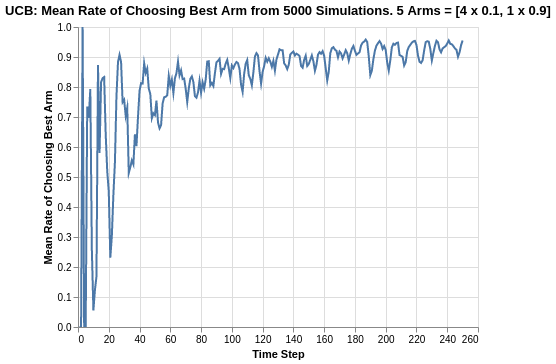

In [42]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
).properties(
    title = "UCB: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [43]:
df_cumreward = df.loc[:,["step", "cum_reward"]].groupby(["step"]).agg("mean").reset_index()

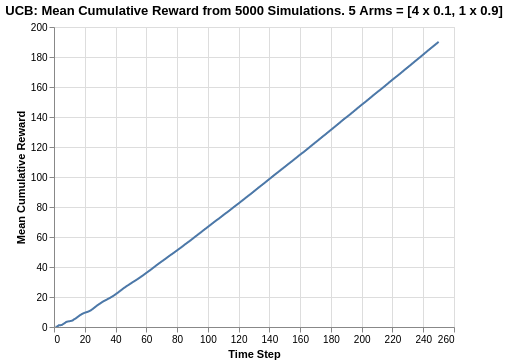

In [44]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward")
).properties(
    title = "UCB: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [45]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.8, 0.8, 0.8, 0.8, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_ucb_results1.tsv", "w+")

# Create simulations for each exploration epsilon value
algo = UCB1([], [])
algo.initialize(n_arms)
results = test_algorithm(algo, arms, 5000, 250)
    
# Store data
for i in range(len(results[0])):
    f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [46]:
df = pd.DataFrame(results).T

In [47]:
df.columns = ["simulation_num", "step", "chosen_arm", "reward", "cum_reward"]

In [48]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [49]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["step", "chose_correct"]].groupby(["step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

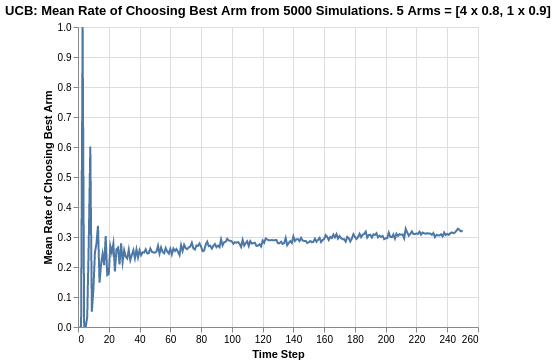

In [50]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
).properties(
    title = "UCB: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

In [51]:
df_cumreward = df.loc[:,["step", "cum_reward"]].groupby(["step"]).agg("mean").reset_index()

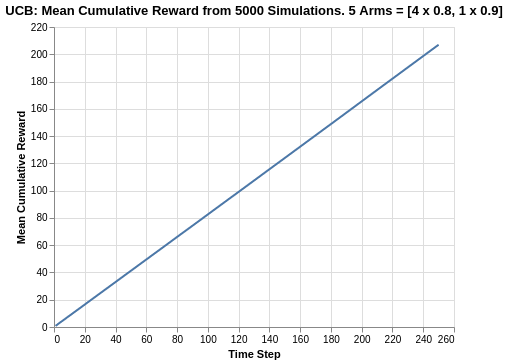

In [52]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward")
).properties(
    title = "UCB: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)